# Part 4: Intuition of gradients and activations

As first step, we copy over the MLP code from last exercise and organize it a bit better:

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos.keys())
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 # Offset of context

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

__Note__: Look below for intuition of why we set weights and biases of our output layer smaller

In [7]:
n_embd = 10
n_hidden = 200

# Network layers
g = torch.Generator().manual_seed(21474783647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Batchnorm. parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Create a minibatch from X
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # FORWARD PASS
    # Emb layer
    emb = C[Xb] # 32, 3, 2
    emb_cat = emb.view(emb.shape[0], -1) # Concat vectors
    hpreact = emb_cat @ W1 # + b1 # Hidden layer preactivation
    # Batch-Normalization
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        # Add SMALL update to the batch-norm running metrics w.o. tracking gradient
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Activation FN
    h = torch.tanh(hpreact) # 32, 100
    # Output layer
    logits = h @ W2 + b2 # 32, 27
    # Loss
    loss = F.cross_entropy(logits, Yb)

    # BACKWARD PASS
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # LR decay
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000: 3.2865
  10000/ 200000: 1.8554
  20000/ 200000: 2.4240
  30000/ 200000: 2.1111
  40000/ 200000: 1.8922
  50000/ 200000: 2.2972
  60000/ 200000: 2.4061
  70000/ 200000: 2.3222
  80000/ 200000: 2.2623
  90000/ 200000: 1.9910
 100000/ 200000: 2.1227
 110000/ 200000: 1.9520
 120000/ 200000: 2.0415
 130000/ 200000: 2.2544
 140000/ 200000: 1.6616
 150000/ 200000: 1.7795
 160000/ 200000: 2.3382
 170000/ 200000: 2.3613
 180000/ 200000: 1.9192
 190000/ 200000: 2.2732


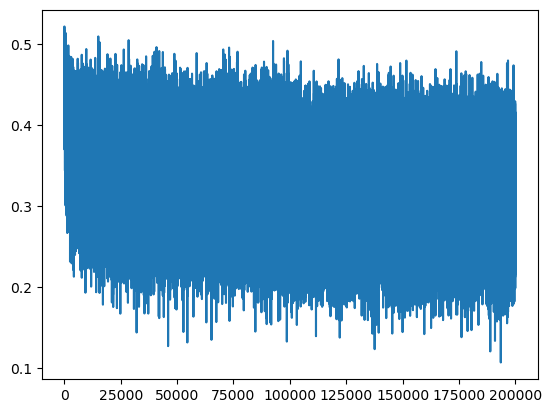

In [9]:
plt.plot(lossi);


### 4.1 First Issue with the weights: Setting initial loss and calculating expected init. loss

__Notes__:
* __Calculating initial expected loss via the loss-fn.__: At the start we would expect to have a uniform distribution (e.g. 1/27) --> We can calc the neg. log. likelihood from that!
* __Negative Effects of this__: Having __larger weights on a few characters__ makes the model __wrongly and confidently incorrect__. We thus want the __logits to be close to zero and rougly equal__ for
all of our characters initially.
* __Why not set the weights to 0 initially__: We do this to achieve __Symmetry Breaking__.

__How can we improve our example here__:
We can set the initial values of the bias to 0 in order not to shift the distribution of the weights and multiply the weights my a very small number, which gets us
close to zero and roughly equal weights at initialization.

Improving this allows the net to directly train on the actually important weights, instead of using the first few thousand iterations to re-adjust the bad
initialization.

__How can we see that we have a problem with initial loss easily__: If the loss plot over time has a hockey-stick appearance (or L-shape), the initial loss is probably way to high
and the weight initialisation needs to be adjusted!

In [10]:
 print(f'Expected initial loss with all characters having the same expectations/probs: {-torch.tensor(1/27.0).log().item()}')

Expected initial loss with all characters having the same expectations/probs: 3.295836925506592


### 4.2 Second problem: Fixing the saturated TanH function

__Intuition of the issue__:
In our initial model, the values of h after (output of first layer AFTER tanh) in a histogram mainly populate
the buckets at -1 and 1, with nearly no activations being inbetween. This happens due to the values being given
to the squashing tanh function.

If we now look at how tanh is backpropagated, this is an issue, as the backpropagation if tanh is (1 - t ** 2).
If our tanh values are -1/1 we get a 0 and __basically kill the gradient backprop__ with it.

This causes the influence of the weights and biases before the tanh on the loss to be basically 0.
Ergo, __their gradient vanishes!__

__Dead Neurons__:
If we look at the activations of h after tanh, if all absolute values of h are close to one for all examples, the neuron
is dead, as it does no longer contribute to improving the loss! This issue happens mainly for activation functions that
have flat tails (tanh, sigmoid, ReLU, ELU). Using a LeakyReLU, Maxout (e.g. function w.o. flat tails) do not suffer this issue!

__How can this happen__:
1. __Bad Luck during initialisation__ of the weights and biases
2. __Too high of a learning rate__ can 'knock out' neurons when they have a very high gradient. This effectively causes them
to fall of the manifold of the model and causes the neuron to be permanently unusable.

__Impact on the model__:
Even without dead neurons, the model will learn way worse if we have many saturated tanh activations close to -1/1. This is because
those neurons rarely get activated due to having such extreme gradients.

__How to fix it__:
We want the values of the pre-activation (hpreact here) close to zero during initialisation. To achieve this, we can also just squash
the weights and biases of the first layer.

### 4.3 How to fix these issues with larger nets

Since here we set everything manually, this is not really feasible for larger architectures. We also want
a way to find the values with whom we squash the weights and biases (e.g. 0.1, 0.01, ...).

Our goal with this is to achieve (roughly) gaussian distributions for all activations in our entire network.
Thus, we need a way to do this consistently, as multiplying with weights squashes the distribution to more extreme values.

__Mathematical Solution__:
Therefore, we want to find a value to multiply with the weights/biases that keeps the distributions exactly gaussian.
We can do this by dividing the weights/biases by the sqrt of the input size.
Of course, PyTorch offers a way to do this: __the torch.nn.init.kaiming_normal function!__

__Importance of paramterizing the kaiming fn__:
Since nowadays a bunch of innovations exist to make deep networks more stable, such as batch normaliztion, residual connections and good optimizers (Adam, RMSProp).
These make the models way more stable and exact initialisation does not matter that much anymore.

__Andrej's tip for practice__:
Just use the normalization by the square root of then input-size (fan-in).


### 4.4 Implementing Batch-Normalization

__Intuition__: We want the pre-activated h values before tan to be roughly gaussian. Batch-Normalization just
__standardizes (normalizes) the pre-activation hidden states__ to be (roughly) __gaussian__!
We can just do this as is, since the operations used (mean, std) are both differentiable.

__Parameters__:
But beware, we want these distributions to only be exactly gaussian at initialization.
For this reason, we add learnable parameters y and beta that __allow the network to learn to shift around
the distributions__ calculated by the Batch-Normalization step.

__Effect__:
In our simple example, we can't expect Batch-Normalization to improve upon our weight initialisation solution,
since tuning one layer manually is still feasible. However, for larger networks, this becomes infeasible and
we will have to make use of BatchNormalization to improve our training!

__Side-Effect__:
Makes each example's h tensor a bit more robust, since it jitters the values by introducing noise from the random
chosen elements in the batch. This __acts as a regularizer basically and may avoid overfitting__! But, since this
randomness is not really a desired property, so __people try to get away from it by using other methods.__

__Calibrating BN at the end of training__:
Since we now need batches to process our data, we 'calibrate' the BN statistics (mean,std) for inference of our
model on the __during training__ on the training-set.

__Tips for practice__:
* __Bias__: gets taken out by BN, so don't use it on layers before since it wastes computation. It does not destroy
computation but is just wasteful.
* __Where to place BN in the net__: After layers with multiplication included (Linear, Conv, ...)
* __Setting BN momentum__: Don't use to large values when using small batch sizes -> This can make training unstable!
* __TRY TO AVOID BN IF POSSIBLE__: Use GroupNormalization or LayerNormalization!

In [14]:
@torch.no_grad() # Decorate to remove gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1) # Concat vectors
    hpreact = emb_cat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # Batch-Normalization
    h = torch.tanh(hpreact) # 32, 100
    logits = h @ W2 + b2 # 32, 27
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0635828971862793
val 2.1119892597198486


In [20]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # Out Shape: (1, block_size, n_emb)
        emb_cat = emb.view(emb.shape[0], -1) # Concat vectors
        hpreact = emb_cat @ W1 #+ b1
        h = torch.tanh(hpreact) # 32, 100
        # Output layer
        logits = h @ W2 + b2 # 32, 27
        # Loss
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, generator=g, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

chapahzabbyllestiemrixgevty.
skaedangjancethalphilscherqui.
zekxsiahceziivor.
jeffrezlynnlindquintzabristaffanvikorathuxtharyxtinkcoubdustelestepoga.
gtaffhyefrahluqie.
prahmsyahnaquo.
boslynncempriasraenakphaadleysondessisorazhrynnloopkeryaraydedeloyoqielyabbreyah.
qreitzabriphpder.
gwesslyndercestabbrenyxxthrykesdanikoamdeejabryparchashroka.
kenzlowekdylcinzlindzey.
suleomingtyeroschelyzzykbarhieliahnafartzayokh.
charquxthadder.
keorahmaryaqisabrishaquatzyimzzyrigfanlayahnysfedgermajcelleavelladaspedver.
keebmitzicaspeapgmundhavellestynxleeghdoslehgrachellyahmarcharmjamermberthilskeyzaerixxnazslyngstonessamaiztalestimesraydangjenetaebraxtzashzellytyafzabriemkhamdylahderreedariahmannihesremesabrithuxlergiffraeteagabrisabrgdecristinxxahdavomberletzasmickshlymylaxkxyndshlogzictolferamthleilamarchellowyannabdigggannahskyilsceldyamariggstontergxleeggsterymarquelliowlanggsoncertyanilogertxgerraedextalissemfadayfoczasuhyamedriqhn.
kehtorettemredmarckhtysxtzaidzayahnisamrevix.
keighclayzunil

# Part 5: Visualizations for debugging/analyzing the net

First, let us create classes for our layers to get closer to a PyTorch-esque style of coding:

In [73]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + self.momentum * xmean
                self.running_var = self.running_var * (1 - self.momentum) + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [75]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

# For intuition of the gain for initialisation look at the diagnostic plots below!!
with torch.no_grad():
    # make last layer less confident (only if we don't use BN) for BN we change the gamma param smaller !
    #layers[-1].weights *= 0.1
    layers[-1].gamma *= 0.1
    # Apply gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [76]:
max_steps = 1000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # Create a minibatch from X
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # FORWARD PASS
    # Emb layer
    emb = C[Xb] # 32, 3, 2
    x = emb.view(emb.shape[0], -1) # Concat vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # BACKWARD PASS
    for layer in layers:
        layer.out.retain_grad() # After debugging: Take out this statement to retain the graph!
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # LR decay
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/   1000: 3.2870


### 5.1 Plotting of forward pass activations

__Intuition__:
We now visualize the forward pass activations of the Tanh layers.
We can thus see if our weight initialisation causes the Tanh layers
to be too saturated. Currently, we use the proposed value of 5/3 as gai
for the weights. If we use something else that is larger (2 or 3), we quickly
see the saturation of the Tanh skyrocket!

__With BatchNorm__:
We will observe a very good plot with nearly the same activations on all layers.
This is of coures the expected effect of using batchnorm. So we can immediately see
the positive effect it has on the activations here!

layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.22 %
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.09 %
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 1.94 %
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.62 %
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 2.09 %


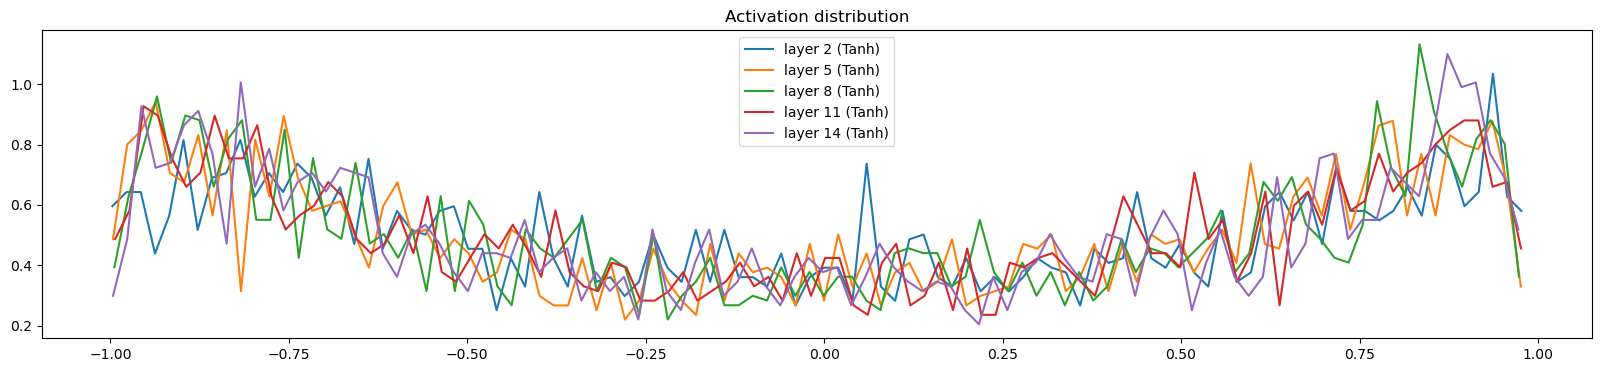

In [77]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f %%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution');

### 5.2 Plotting of gradient distribution
__Intuition__:
We now look at the gradient distribution of our activation function Tanh in the same way.
From this diagnostic plot we can see, that our gradients are neither shrinking nor exploding
in each of the activation layers.

__If the gain were too small, we would see gradients exploding or vanishing!__
__Remember, we want all the gradient activations to be roughly gaussian!!__

__--> Because of this, before BN (or other normalization techniques) became know, it was
incredibly difficult to find the right gain!__

__With BatchNorm__:
Activation distribution looks very gaussian and roughly equal for all activation functions,
as was our goal with BN!

layer 2 (      Tanh): mean -0.000000, std 3.034773e-03 %
layer 5 (      Tanh): mean -0.000000, std 2.843007e-03 %
layer 8 (      Tanh): mean -0.000000, std 2.662445e-03 %
layer 11 (      Tanh): mean -0.000000, std 2.479312e-03 %
layer 14 (      Tanh): mean +0.000000, std 2.277823e-03 %


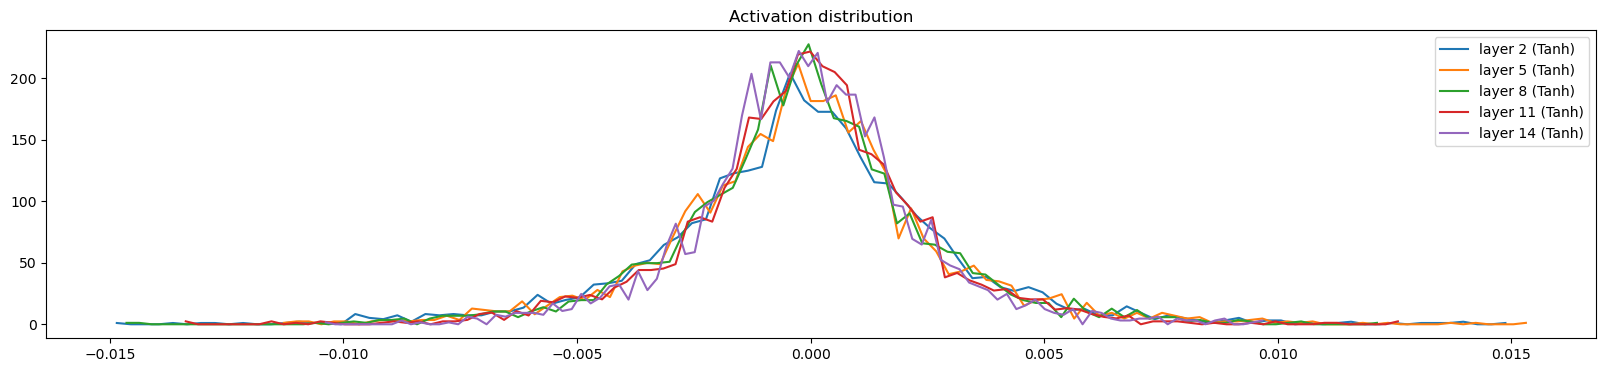

In [79]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e %%' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution');

### 5.3 Plotting the weights gradient distribution

__Intuition__:
Doing diagnostic plots on this is pretty interesting, as we are mainly concerned about
__training these parameters!__ We are mainly interested in comparing the magnitudes of
the gradients here. If some are extreme outliers, they will train way faster than other
layers due to receiving larger updates!

__Gradient:Data Ratio intuition__:
Gives a sense of what is the scale of the data distribution compared to the scale of the weight distribution.
This is important, because the gradient is added to the data, and if the difference is to large we have an
issue with overriding the data or not having an effect! __However this metric is not that informative, instead
we should plot the update to data ratio!__

__With BatchNorm__:
We can see the gradient data ratio is now more equal than before, so BN helps here too!

weight |   (27, 10) | mean -0.000000 | std 8.247248e-03 | grad:data ratio 8.238846e-03
weight |  (30, 100) | mean -0.000123 | std 6.649372e-03 | grad:data ratio 2.127438e-02
weight | (100, 100) | mean +0.000091 | std 6.160564e-03 | grad:data ratio 3.684821e-02
weight | (100, 100) | mean -0.000068 | std 5.717535e-03 | grad:data ratio 3.389937e-02
weight | (100, 100) | mean +0.000024 | std 5.442536e-03 | grad:data ratio 3.242403e-02
weight | (100, 100) | mean -0.000045 | std 4.934750e-03 | grad:data ratio 2.939288e-02
weight |  (100, 27) | mean +0.000046 | std 9.184223e-03 | grad:data ratio 5.510815e-02


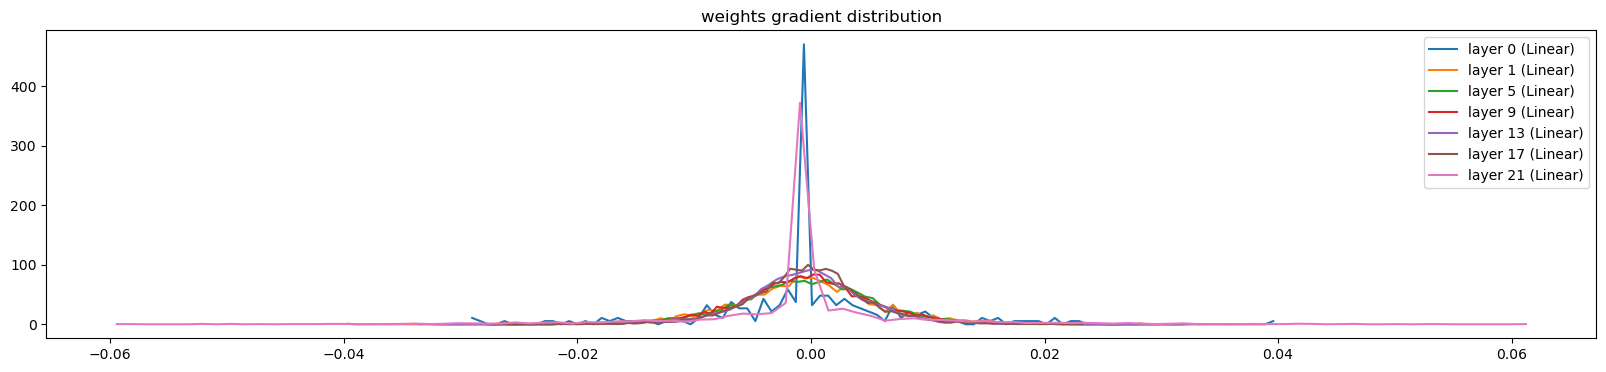

In [80]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters): # exclude output layer
    t = p.grad
    if p.ndim == 2:
        print('weight | %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('weights gradient distribution');

### 5.4 Gradient update to data plot

__Intuition__:
We previously looked at the gradient to data ratio. But since we are actually more interested in
the updates on our weights, we will plot this. We calculate this metric from the learning rate multiplied by
the std of the gradient of a parameter, divided by the log of the std of the data of the parameter (e.g. the weights).

__--> This gives us a measure on how great the updates on the weights are!__

Note that the ratios of the parameter update values __should be in the magnitude of ~1e-3__.

__Andrej's tips for using this plot__:
Make sure it's not too much above for all parameters!
* __Ratio is much larger than 1e-3__: Updates are probably too fast and make learning unstable! In our example we artificially inflate the last layer due to shrinking the weights, so it's ok here.
* __Ratio way lower than 1e-3__: If it is too low, then the __learning rate is probably too slow/low!__
Ergo we can also use this as a measure to configure the learning rate!

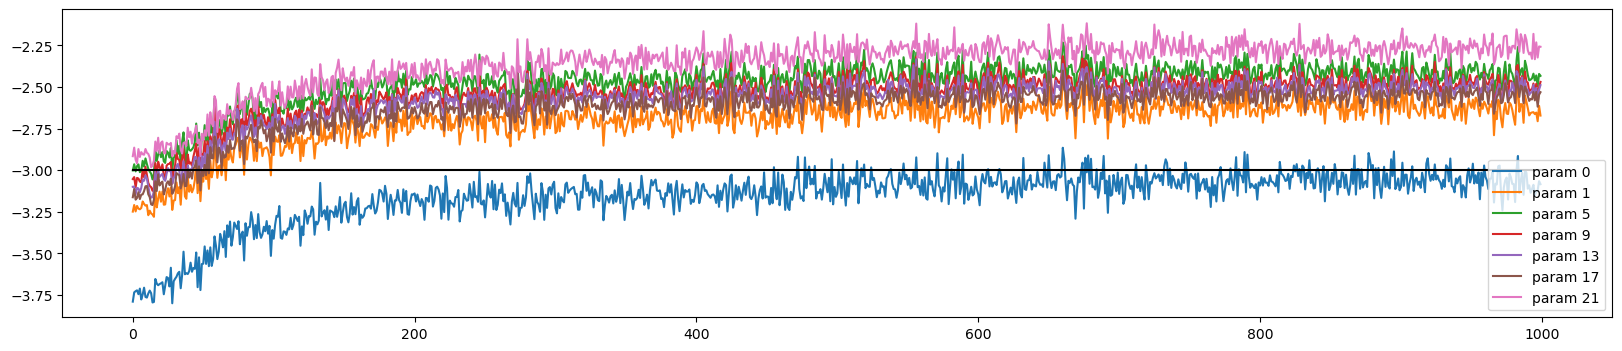

In [81]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters): # exclude output layer
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # ratios should be at roughly or below 1e-3
plt.legend(legends);

The last layer here is an outlier, since we made it less confident using a multiplication by a small factor! But,we can see that this stabilizes very quickly.